In [1]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

In [2]:
XL = matplotlib.image.imread('./data/im0.ppm')
XR = matplotlib.image.imread('./data/im8.ppm')

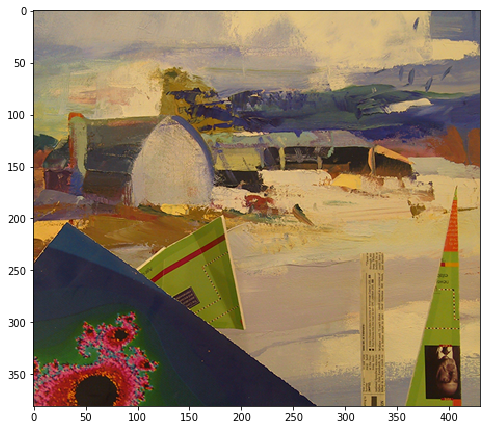

In [3]:
plt.figure(figsize=(8,8))
plt.imshow(XL)
plt.show()

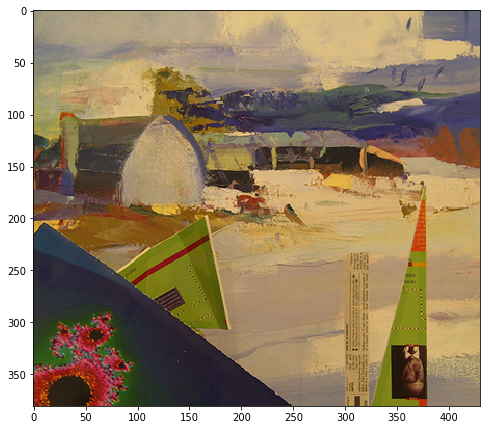

In [4]:
plt.figure(figsize=(8,8))
plt.imshow(XR)
plt.show()

### Create the disparity map

In [5]:
disparity_matrix = np.zeros((XR.shape[0], XR.shape[1]-40))
for y in range(XR.shape[0]):
    for x in range(XR.shape[1]-40):
        pivot = XR[y,x,:]
        search_space = XL[y,x:x+40,:]
#         print(pivot, search_space,np.abs(search_space - pivot).sum(axis=1), 
#               np.argmin(np.absolute(search_space - pivot).sum(axis=1)))
        disparity_matrix[y,x] = np.argmin(np.abs(search_space - pivot).sum(axis=1))

In [6]:
disparity_matrix.shape

(381, 390)

### Vectorize the disparity matrix and draw histogram

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6097: UserWarning: 2D hist input should be nsamples x nvariables;
 this looks transposed (shape is 381 x 390)
  '(shape is %d x %d)' % inp.shape[::-1])


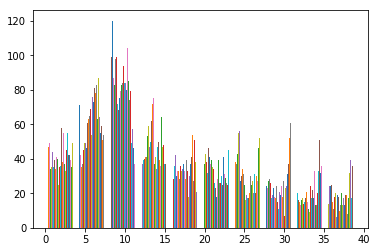

In [7]:
plt.hist(disparity_matrix)
plt.show()

In [8]:
disparity_matrix = disparity_matrix.astype('int')
disparity_dict = {i:0 for i in range(40)}
for y in range(disparity_matrix.shape[0]):
    for x in range(disparity_matrix.shape[1]):
        disparity_dict[disparity_matrix[y, x]] += 1

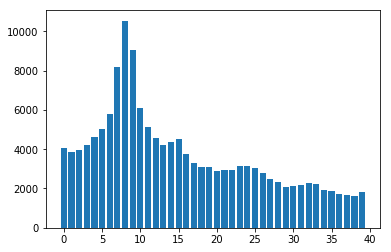

In [9]:
plt.bar(list(range(40)), list(disparity_dict[i] for i in range(40)))
plt.show()

### K-means

k  2
[25  7]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


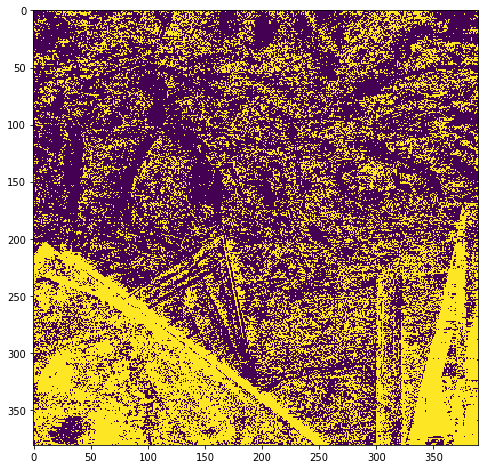

k  3
[ 6 31 18]


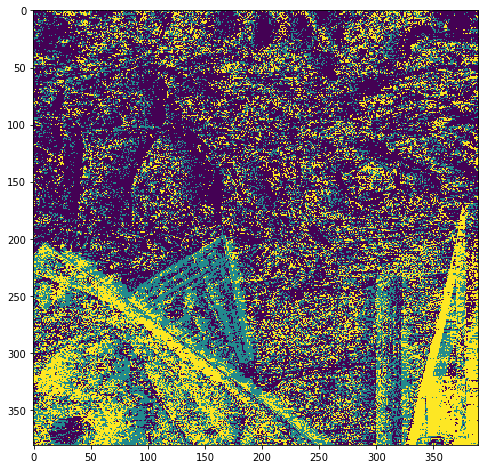

k  4
[33 22  5 13]


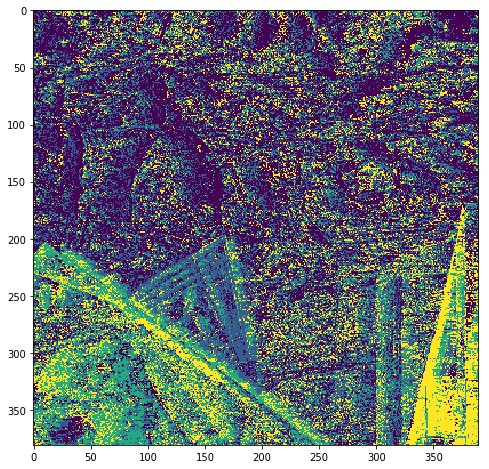

k  5
[ 1  6 19 31 11]


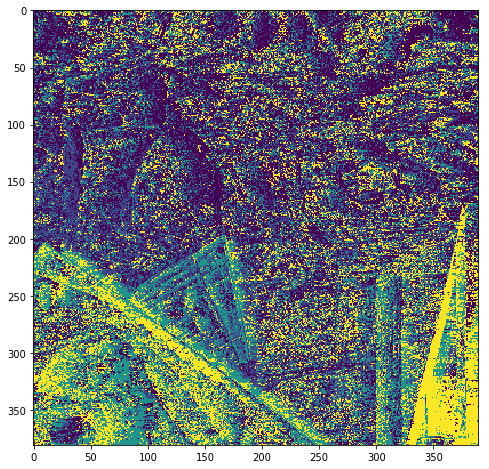

k  6
[ 6 17 34 25 10  1]


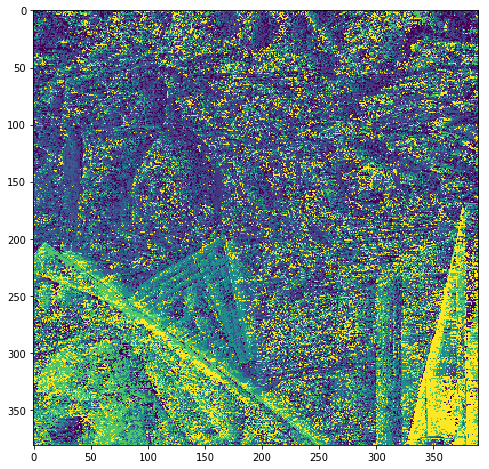

In [11]:
# initalize random centeroids
def kmeans(x, n_centers):
    centers = np.random.randint(0,40,size=n_centers)
    x_vector = x.reshape(x.shape[0]*x.shape[1],)
    len_x_vector = len(x_vector)
    while True:
        old_centers = centers
        diff = np.abs(x_vector - centers.reshape(n_centers,1)).T
        classify = np.zeros((len_x_vector, n_centers))
        classify[np.arange(len(diff)), diff.argmin(1)] = 1
        centers = (np.dot(x_vector, classify)/np.sum(classify, axis=0)).astype('int')
        if np.array_equal(centers, old_centers):
            print(centers)
            classified = classify.argmax(axis=1)
            for i in range(n_centers):
                classified[classified==i] = centers[i]
            classified = classified.reshape(x.shape[0],x.shape[1])
            break
            
    return classified

for k in range(2,7):
    print("k ", k)
    dist_gray_scale = kmeans(disparity_matrix, k)
    plt.figure(figsize=(8,8))
    plt.imshow(dist_gray_scale)
    plt.show()

### GMM

k  2


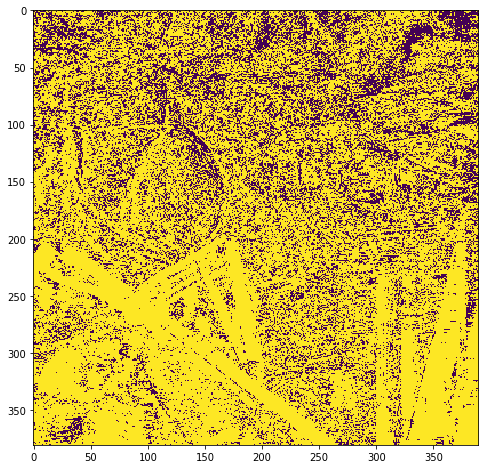

k  3


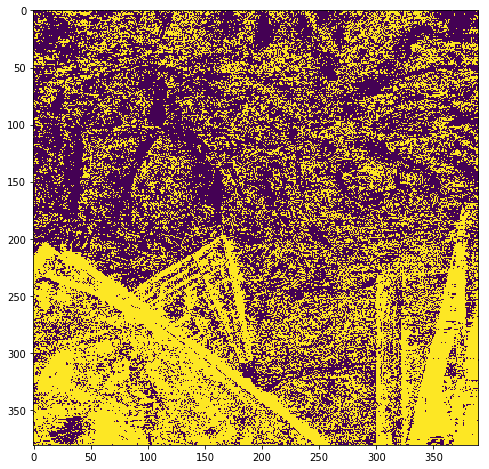

k  4


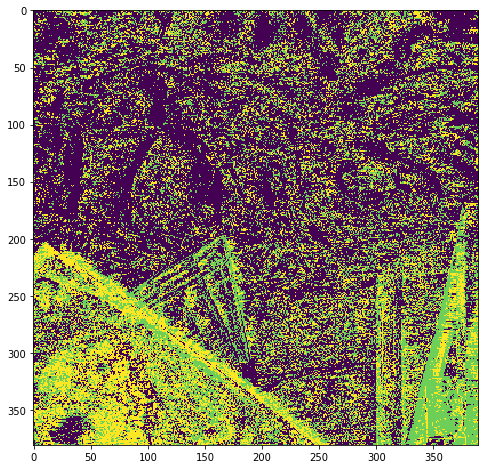

k  5


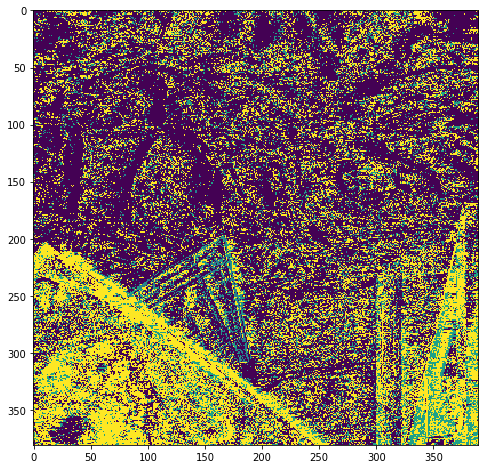

k  6


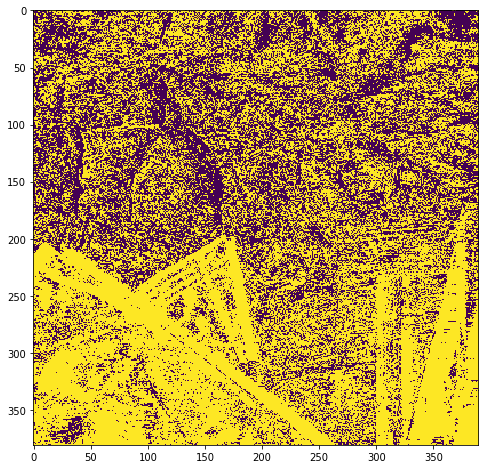

k  7


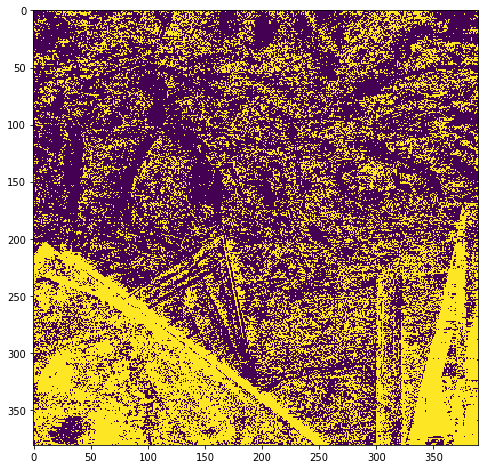

In [140]:
import sys
# initalize random centeroids
def kmeans(x, n_gaussians):
    x_vector = x.reshape(x.shape[0]*x.shape[1],)
    len_x_vector = len(x_vector)
    means = np.random.choice(40,size=n_gaussians,replace=False).reshape(n_gaussians,1)
    variances = np.sum(np.square((x_vector - means)),
                           axis=1).reshape((n_gaussians,1))/(len_x_vector-1)
    probability_class = np.ones(shape=(n_gaussians, 1))/n_gaussians
    while True:
        old_means = means
        old_variances = variances
        probability_x_given_class = (1/np.sqrt(2*np.pi* variances)
                                  )*np.exp((np.square(x_vector - means))/(2*variances))
        marginal_probability_x_class = probability_class * probability_x_given_class
        probability_class_given_x =  marginal_probability_x_class/marginal_probability_x_class.sum(axis=0)
        means = (probability_class_given_x * x_vector).sum(axis=1)/probability_class_given_x.sum(axis=1)
        means = means.reshape(n_gaussians,1)
        variances = np.sum(probability_class_given_x * np.square((x_vector - means)),
                           axis=1)/probability_class_given_x.sum(axis=1)
        variances = variances.reshape(n_gaussians,1)
        if np.sum(means-old_means) < 0.01:
            classified = np.zeros(len(x_vector))
            classified = probability_x_given_class.argmax(axis=0)
            for i in range(n_gaussians):
                classified[classified==i] = int(means[i])
            classified = classified.reshape(x.shape[0],x.shape[1])
            break

    return classified

for k in range(2,8):
    print("k ", k)
    dist_gray_scale = kmeans(disparity_matrix, k)
    plt.figure(figsize=(8,8))
    plt.imshow(dist_gray_scale)
    plt.show()